In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
 95% 536M/565M [00:03<00:00, 66.5MB/s]
100% 565M/565M [00:03<00:00, 181MB/s] 


In [ ]:
!unzip fashion-product-images-small.zip -d fashion_data

Streaming output truncated to the last 5000 lines.
  inflating: fashion_data/myntradataset/images/25426.jpg  
  inflating: fashion_data/myntradataset/images/25427.jpg  
  inflating: fashion_data/myntradataset/images/25429.jpg  
  inflating: fashion_data/myntradataset/images/2543.jpg  
  inflating: fashion_data/myntradataset/images/25430.jpg  
  inflating: fashion_data/myntradataset/images/25431.jpg  
  inflating: fashion_data/myntradataset/images/25432.jpg  
  inflating: fashion_data/myntradataset/images/25433.jpg  
  inflating: fashion_data/myntradataset/images/25434.jpg  
  inflating: fashion_data/myntradataset/images/25435.jpg  
  inflating: fashion_data/myntradataset/images/25436.jpg  
  inflating: fashion_data/myntradataset/images/25437.jpg  
  inflating: fashion_data/myntradataset/images/25438.jpg  
  inflating: fashion_data/myntradataset/images/25439.jpg  
  inflating: fashion_data/myntradataset/images/2544.jpg  
  inflating: fashion_data/myntradataset/images/25440.jpg  
  infla

In [9]:
import pandas as pd
import os
import shutil
import random

# Load CSV metadata
df = pd.read_csv("fashion_data/styles.csv", on_bad_lines='skip')

# Pick 6 categories (adjust based on what exists in your CSV)
categories = ['Tops', 'Dresses', 'Footwear', 'Handbags', 'Jackets', 'Bottoms']

subset_dir = "fashion_subset"
os.makedirs(subset_dir, exist_ok=True)

for cat in categories:
    os.makedirs(os.path.join(subset_dir, cat), exist_ok=True)
    cat_df = df[df['articleType'] == cat]

    # Determine the number of samples to take
    num_samples = min(150, len(cat_df))

    # Only sample if there are items to sample
    if num_samples > 0:
        sampled = cat_df.sample(n=num_samples, random_state=42)

        for img_id in sampled['id']:
            fname = str(img_id) + '.jpg'
            src_path = os.path.join("fashion_data/images", fname)
            dst_path = os.path.join(subset_dir, cat, fname)
            if os.path.exists(src_path):
                shutil.copy(src_path, dst_path)
    else:
        print(f"Skipping category '{cat}' as it has no items to sample.")

Skipping category 'Footwear' as it has no items to sample.
Skipping category 'Bottoms' as it has no items to sample.


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80-20 split
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    subset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    subset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 480 images belonging to 6 classes.
Found 120 images belonging to 6 classes.


In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False  # freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 555ms/step - accuracy: 0.5516 - loss: 1.1780 - val_accuracy: 0.8417 - val_loss: 0.4859
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 498ms/step - accuracy: 0.9024 - loss: 0.2660 - val_accuracy: 0.8667 - val_loss: 0.4458
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 505ms/step - accuracy: 0.9430 - loss: 0.1325 - val_accuracy: 0.8500 - val_loss: 0.4089
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 421ms/step - accuracy: 0.9802 - loss: 0.0955 - val_accuracy: 0.8750 - val_loss: 0.4215
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 506ms/step - accuracy: 0.9829 - loss: 0.0719 - val_accuracy: 0.8750 - val_loss: 0.4163
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 427ms/step - accuracy: 0.9853 - loss: 0.0582 - val_accuracy: 0.8667 - val_loss: 0.4291
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 503ms/step - accuracy: 0.9984 - loss: 0.0353 - val_accuracy: 0.8417 - val_loss: 0.4464
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 427ms/step - accuracy: 0.9975 - loss: 0.0316 - val_accuracy: 0.8583 - va

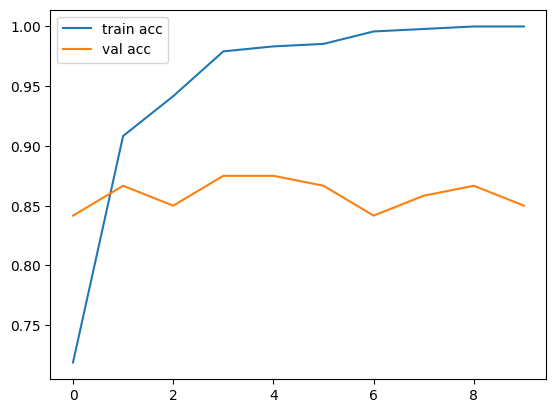

In [13]:
# Optional: plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [14]:
# Evaluate model on validation set
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step - accuracy: 0.8623 - loss: 0.4819
Validation Accuracy: 86.67%


In [15]:
# Save model
model.save("fashion_classifier.h5")

In [16]:
model.save("fashion_classifier.keras")